In [21]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from tabulate import tabulate
import seaborn as sns
from random import sample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, accuracy_score

## Data Preprocessing

### Data Loading

In [22]:
df = pd.read_csv('data.csv', index_col=False)
print("Data Shape: {}".format(df.shape))
df.head()

Data Shape: (569, 32)


,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [23]:
# saving X and y
df = df.drop("id", axis=1) # don't want id to be included as a factor
X = df.drop("diagnosis", axis=1)
y = df["diagnosis"]

# one hot encoding y
le = LabelEncoder()
y = le.fit_transform(y)

print("X shape: {}".format(X.shape))
print("y shape: {}".format(y.shape))

X shape: (569, 30)
y shape: (569,)


### Data Exploration

In [24]:
# Understanding ranges of features
tab = []
for col in X.columns:
  row = []
  row.append(col)
  row.append(type(X[col][0]).__name__)

  if isinstance(X[col][0], np.float64):
    row.append("Range: {:.2f} - {:.2f}".format(X[col].min(), X[col].max()))
  else:
    row.append(sorted(X[col].unique().tolist()))

  tab.append(row)

print(tabulate(tab, tablefmt="grid", headers=["Column", "Type", "Values"]))

+-------------------------+---------+-------------------------+
| Column                  | Type    | Values                  |
+=========================+=========+=========================+
| radius_mean             | float64 | Range: 6.98 - 28.11     |
+-------------------------+---------+-------------------------+
| texture_mean            | float64 | Range: 9.71 - 39.28     |
+-------------------------+---------+-------------------------+
| perimeter_mean          | float64 | Range: 43.79 - 188.50   |
+-------------------------+---------+-------------------------+
| area_mean               | float64 | Range: 143.50 - 2501.00 |
+-------------------------+---------+-------------------------+
| smoothness_mean         | float64 | Range: 0.05 - 0.16      |
+-------------------------+---------+-------------------------+
| compactness_mean        | float64 | Range: 0.02 - 0.35      |
+-------------------------+---------+-------------------------+
| concavity_mean          | float64 | Ra

### Class Imbalance

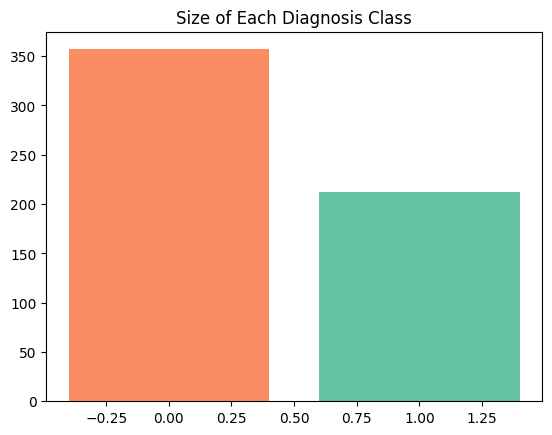

Class: 1; Percentage: 0.37258347978910367
Class: 0; Percentage: 0.6274165202108963


In [25]:
# Plotting distribution of y classes
counts = Counter(y)
keys = []
for key in counts.keys():
  keys.append(key)

plt.bar(counts.keys(), counts.values(), color=plt.cm.Set2.colors)
plt.title("Size of Each Diagnosis Class")
plt.show()

for key in counts.keys():
  print("Class: {};".format(key), "Percentage: {}".format(counts[key]/len(y)))


Balanced Data Shape: (524, 31)


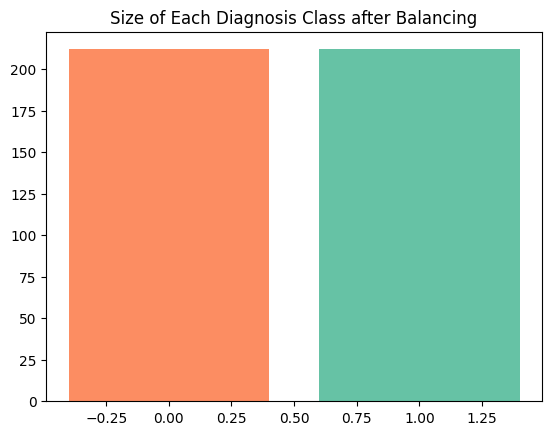

Class: 1; Percentage: 0.5
Class: 0; Percentage: 0.5


In [26]:
min_key = min(counts, key=counts.get)
min_count = counts[min_key]
np.random.seed(0)

# Balancing dataset
bal_ind = []
for key in keys:
  indices = [i for i in range(len(y)) if y[i] == key]
  if key == min_key:
    bal_ind += indices
  else:
    bal_ind += sample(indices, min_count)

X_bal = X.iloc[bal_ind]
y_bal = y[bal_ind]

# Saving balanced dataset
df_bal = pd.concat([X_bal, pd.DataFrame({'diagnosis': y_bal})], axis=1)
df_bal.to_csv("data_balanced.csv", index=False)
print("Balanced Data Shape: {}".format(df_bal.shape))

# Plotting balanced dataset
counts = Counter(y_bal)
keys = []
for key in counts.keys():
  keys.append(key)

plt.bar(counts.keys(), counts.values(), color=plt.cm.Set2.colors)
plt.title("Size of Each Diagnosis Class after Balancing")
plt.show()

for key in counts.keys():
  print("Class: {};".format(key), "Percentage: {}".format(counts[key]/len(y_bal)))

### Dimensionality Reduction

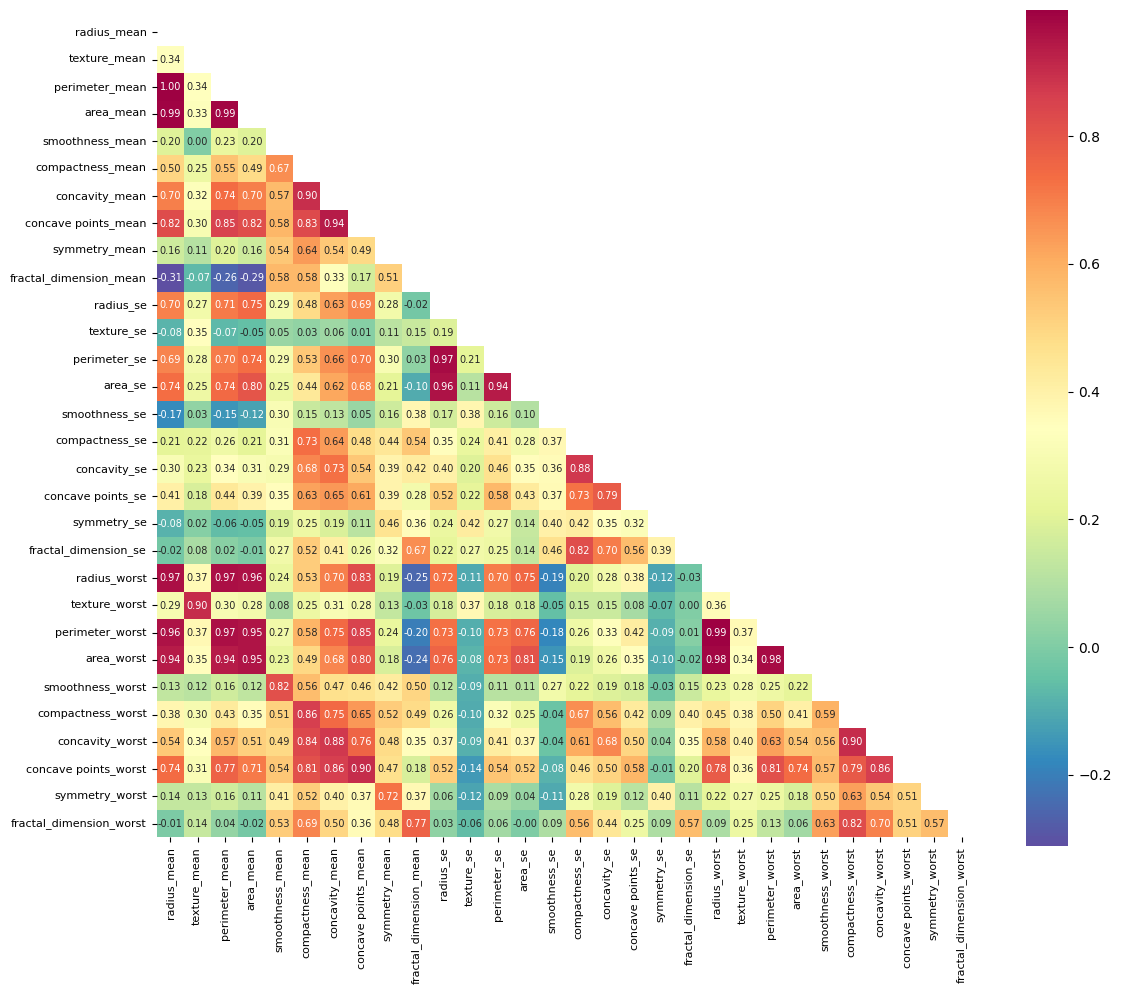

In [27]:
correlation_matrix = X_bal.corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="Spectral_r", fmt=".2f", annot_kws={"size": 7}, square=True, mask=mask)
plt.xticks(rotation=90, fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.show()

In [28]:
# # Find feature pairs with correlation ≥ 0.95
# tri = correlation_matrix.where(np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1))

# high_corr_pairs = tri.stack().reset_index()
# high_corr_pairs.columns = ['Feature1', 'Feature2', 'Correlation']
# high_corr_pairs = high_corr_pairs[high_corr_pairs['Correlation'] >= 0.95]

# print(high_corr_pairs)

In [29]:
# # Removing redundant features
# X_redundant = X_bal.drop(columns=["perimeter_mean", "area_mean", "perimeter_se", "area_se"])
# df_redundant = pd.concat([X_redundant, pd.DataFrame({'diagnosis': y_bal})], axis=1)
# df_redundant.to_csv("data_redundant.csv", index=False)

# print(df_redundant.shape)

<!-- ### Modeling -->

In [30]:
# Scaling dataset
from sklearn.preprocessing import StandardScaler


# Splitting each dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_bal, X_test_bal, y_train_bal, y_test_bal = train_test_split(X_bal, y_bal, test_size=0.2, random_state=42)

# scaling data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train_bal = scaler.fit_transform(X_train_bal)
X_test_bal = scaler.transform(X_test_bal)

# X_train_redundant, X_test_redundant, y_train_redundant, y_test_redundant = train_test_split(X_redundant, y_bal, test_size=0.2, random_state=42)

In [33]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print("Accuracy on original data: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

# Coefficients and Odds Ratios
coefficients = lr.coef_[0]

# Display feature importance using coefficients and odds ratios
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})
print("\nFeature Importance (Coefficient):")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_bal, y_train_bal)
y_pred_bal = lr.predict(X_test_bal)
print("Accuracy on balanced data: {:.2f}%".format(accuracy_score(y_test_bal, y_pred_bal) * 100))

# lr = LogisticRegression(max_iter=1000)
# lr.fit(X_train_redundant, y_train_redundant)
# y_pred_redundant = lr.predict(X_test_redundant)
# print("Accuracy on redundant data: {:.2f}%".format(accuracy_score(y_test_redundant, y_pred_redundant) * 100))

Accuracy on original data: 97.37%

Feature Importance (Coefficient):
                    Feature  Coefficient
21            texture_worst     1.350606
10                radius_se     1.268178
28           symmetry_worst     1.208200
7       concave points_mean     1.119804
26          concavity_worst     0.943053
13                  area_se     0.907186
20             radius_worst     0.879840
23               area_worst     0.841846
6            concavity_mean     0.801458
27     concave points_worst     0.778217
12             perimeter_se     0.610583
22          perimeter_worst     0.589453
24         smoothness_worst     0.544170
3                 area_mean     0.465210
0               radius_mean     0.431904
2            perimeter_mean     0.393432
1              texture_mean     0.387326
14            smoothness_se     0.313307
17        concave points_se     0.311300
29  fractal_dimension_worst     0.157414
4           smoothness_mean     0.071667
25        compactness_worst  

Accuracy on PCA data: 93.86%


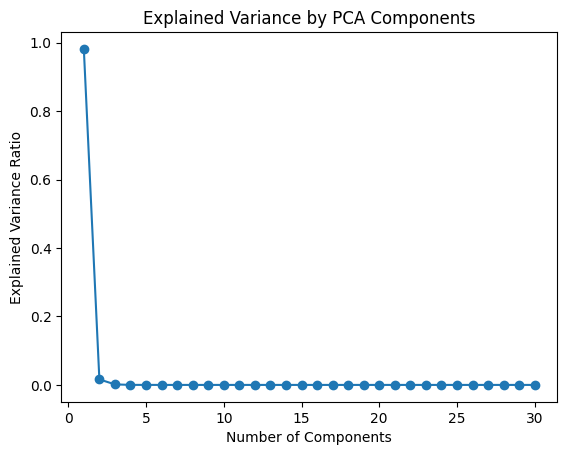

In [60]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)
X_pca = pca.transform(X)

explained_variance = pca.explained_variance_ratio_
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o')
plt.title("Explained Variance by PCA Components")
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance Ratio")

# keeping first 2 components
X_pca = X_pca[:, :2]

X_pca_train, X_pca_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# scaling data
scaler = StandardScaler()
X_pca_train = scaler.fit_transform(X_pca_train)
X_pca_test = scaler.transform(X_pca_test)

lr = LogisticRegression(max_iter=1000)
lr.fit(X_pca_train, y_train)
y_pred = lr.predict(X_pca_test)
print("Accuracy on PCA data: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))


In [57]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

lda = LDA(n_components=1)
X_lda = lda.fit_transform(X, y)

X_lda_train, X_lda_test, y_train, y_test = train_test_split(X_lda, y, test_size=0.2, random_state=42)
# scaling data
scaler = StandardScaler()
X_lda_train = scaler.fit_transform(X_lda_train)
X_lda_test = scaler.transform(X_lda_test)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_lda_train, y_train)
y_pred = lr.predict(X_lda_test)
print("Accuracy on LDA data: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Accuracy on LDA data: 97.37%
